## ANN approach for ARM


In [1]:
"""
@author: Dr. H K Patel, Pankaj, Aditya
"""
import time
start = time.time()
from sklearn.decomposition import NMF
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_auc_score

import warnings
warnings.simplefilter("ignore", UserWarning)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
cols = ['1','2','3','4','5','6','7','8','9','10','11','12',
        '13','14','15','16','17','18','19','20']
       # '23','24','25','26','27','28','29','30','31','32']

df = pd.read_csv("dataset/shopdata.csv", sep = ",", 
                 names = cols, engine = "python")
data = np.array(df)
df.head(5)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,chutney,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,turkey,avocado,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,mineral water,milk,energy bar,whole wheat rice,green tea,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [3]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
count,7501,5747,4389,3345,2529,1864,1369,981,654,395,256,154,87,47,25,8,4,4,3,1
unique,115,117,115,114,110,106,102,98,88,80,66,50,43,28,19,8,3,3,3,1
top,mineral water,mineral water,mineral water,mineral water,green tea,french fries,green tea,green tea,green tea,green tea,low fat yogurt,green tea,green tea,green tea,magazines,cake,frozen smoothie,protein bar,mayonnaise,olive oil
freq,577,484,375,201,153,107,96,67,57,31,22,15,8,4,3,1,2,2,1,1


In [4]:
df.shape

(7501, 20)

In [5]:
def get_unique_items(data):
    ncol = data.shape[1]
    items = set()
    for c in range(ncol):
        items = items.union(data[:,c])
    items = np.array(list(items))
    items = items[items != np.array(None)]

    return np.unique(items)

In [6]:
def get_onehot_items(data,unique_items):
    onehot_items = np.zeros((len(data),len(unique_items)),dtype = np.int)
    for i, r in enumerate(data):
        for j, c in enumerate(unique_items):
            onehot_items[i,j] = int(c in r)
            
    return onehot_items


In [7]:
def get_items_from_ohe(ohe,unique_items):
    return unique_items[np.flatnonzero(ohe)]

In [8]:
unique_items = get_unique_items(data)
onehot_items = np.array(get_onehot_items(data, unique_items))


n = 15
item_counts = (onehot_items != 0).sum(0)
items_max_args = item_counts.argsort()[-n:][::-1]
ic = pd.DataFrame({"Items":unique_items[items_max_args], "Frequency":item_counts[items_max_args]})


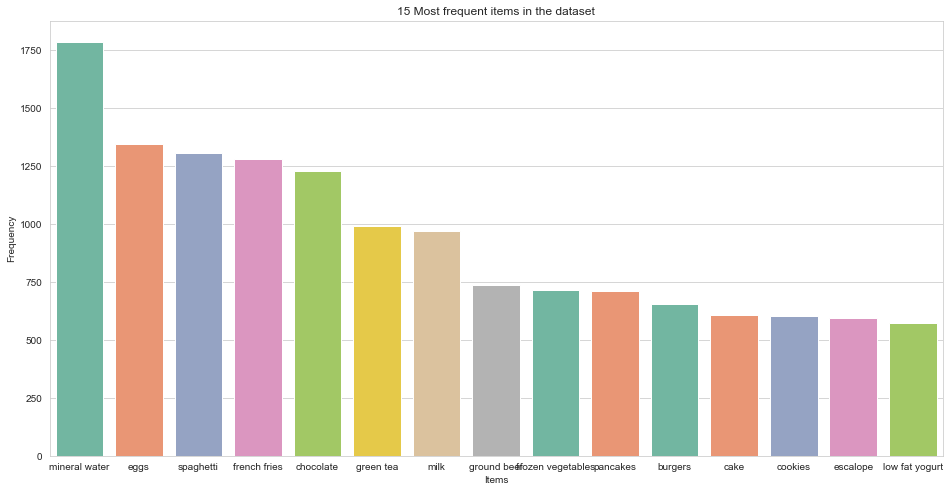

In [9]:
fig = plt.figure(figsize = (16,8))
sns.barplot(x="Items", y="Frequency", data=ic, palette=sns.color_palette("Set2", 10))
plt.xlabel("Items")
plt.ylabel("Frequency")
plt.title(str(n) + " Most frequent items in the dataset")
plt.show()

In [10]:
train_test_split = np.random.rand(len(onehot_items)) < 0.80
train_x = onehot_items[train_test_split]
test_x = onehot_items[~train_test_split]
print()


In [11]:
train_validation_split = np.random.rand(len(train_x)) < 0.80
validation_x = train_x[~train_validation_split]
train_x = train_x[train_validation_split]

In [12]:
def weight_variable(weight_name, weight_shape):
    return tf.get_variable(name = "weight_" + weight_name,shape = weight_shape, 
            initializer = tf.contrib.layers.xavier_initializer()) 

In [13]:
def bias_variable(bias_shape):
    initial = tf.constant(0.1, shape = bias_shape)
    return tf.Variable(initial)

In [14]:
def encoder(x):
    l1 = tf.nn.softsign(tf.add(tf.matmul(x,e_weights_h1),e_biases_h1))
    l2 = tf.nn.softsign(tf.add(tf.matmul(l1,e_weights_h2),e_biases_h2))
    l3 = tf.nn.softsign(tf.add(tf.matmul(l2,e_weights_h3),e_biases_h3))
    l4 = tf.nn.sigmoid(tf.add(tf.matmul(l3,e_weights_h4),e_biases_h4))
    return l4

In [15]:
def decoder(x):
    l1 = tf.nn.softsign(tf.add(tf.matmul(x,d_weights_h1),d_biases_h1))
    l2 = tf.nn.softsign(tf.add(tf.matmul(l1,d_weights_h2),d_biases_h2))
    l3 = tf.nn.softsign(tf.add(tf.matmul(l2,d_weights_h3),d_biases_h3))
    l4 = tf.nn.sigmoid(tf.add(tf.matmul(l3,d_weights_h4),d_biases_h4))
    return l4

#### Terminology

input_dim = 169

n_hidden_1 = 128
n_hidden_2 = 64
n_hidden_3 = 32
n_hidden_4 = 16

training_epochs = 30
batch_size = 50
total_batches = (train_x.shape[0] // batch_size)

learning_rate = 0.00002
keep_prob = 0.6
l2_reg_rate = 0.00001


In [31]:
input_dim = 120

n_hidden_1 = 108
n_hidden_2 = 64
n_hidden_3 = 32
n_hidden_4 = 16

training_epochs = 18
batch_size = 50
total_batches = (train_x.shape[0] // batch_size)

learning_rate = 0.0002 #0.0002
keep_prob = 0.8
l2_reg_rate = 0.000001

In [32]:
tf.reset_default_graph()

In [33]:
is_training = tf.placeholder_with_default(False, shape = ())
X = tf.placeholder(tf.float32, shape=[None,input_dim])
X_drop = tf.contrib.layers.dropout(X, keep_prob, is_training = is_training)
#X_drop = tf.contrib.layers.dropout(X, keep_prob, noise_shape=None, is_training=True, outputs_collections=None, scope=None, seed=None )
print("X_drop", X_drop)

X_drop Tensor("Dropout/cond/Merge:0", shape=(?, 120), dtype=float32)


##### --------------------- Encoder Variables --------------- ####

In [34]:
e_weights_h1 = weight_variable("el1",[input_dim, n_hidden_1])
e_biases_h1 = bias_variable([n_hidden_1])

e_weights_h2 = weight_variable("el2",[n_hidden_1, n_hidden_2])
e_biases_h2 = bias_variable([n_hidden_2])

e_weights_h3 = weight_variable("el3",[n_hidden_2, n_hidden_3])
e_biases_h3 = bias_variable([n_hidden_3])

e_weights_h4 = weight_variable("el4",[n_hidden_3, n_hidden_4])
e_biases_h4 = bias_variable([n_hidden_4])
e_biases_h4

<tf.Variable 'Variable_3:0' shape=(16,) dtype=float32_ref>



#### --------------------- Decoder Variables --------------- ####

In [35]:
d_weights_h1 = weight_variable("dl1",[n_hidden_4, n_hidden_3])
d_biases_h1 = bias_variable([n_hidden_3])

d_weights_h2 = weight_variable("dl2",[n_hidden_3, n_hidden_2])
d_biases_h2 = bias_variable([n_hidden_2])

d_weights_h3 = weight_variable("dl3",[n_hidden_2, n_hidden_1])
d_biases_h3 = bias_variable([n_hidden_1])

d_weights_h4 = weight_variable("dl4",[n_hidden_1, input_dim])
d_biases_h4 = bias_variable([input_dim])

In [36]:
encoded = encoder(X_drop)
print("HHHH==",encoded)
decoded = decoder(encoded)
print("MMMM==", decoded) 

HHHH== Tensor("Sigmoid:0", shape=(?, 16), dtype=float32)
MMMM== Tensor("Sigmoid_1:0", shape=(?, 120), dtype=float32)


In [37]:
regularizer = tf.contrib.layers.l2_regularizer(l2_reg_rate)
reg_loss = regularizer(e_weights_h1) + regularizer(e_weights_h2) + regularizer(e_weights_h3) + regularizer(e_weights_h4) 
cost_function = -tf.reduce_mean(((X * tf.log(decoded)) + ((1 - X) * tf.log(1 - decoded)))) + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost_function)

In [40]:
with tf.Session() as session:
    Tr_loss=[]
    Val_loss=[]
    tf.global_variables_initializer().run()
    print("Epoch","  ","Tr. Loss"," ","Val. Loss")
    for epoch in range(training_epochs):
        for b in range(total_batches):
            offset = (b * batch_size) % (train_x.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :] 
            _, c = session.run([optimizer, cost_function],feed_dict={X: batch_x, is_training: True})
    
        tr_c = session.run(cost_function,feed_dict={X: train_x, is_training: False})
        val_c = session.run(cost_function,feed_dict={X: validation_x, is_training: False})
        print(epoch+1,"\t",tr_c," ",val_c)
        Tr_loss.append(tr_c)
        Val_loss.append(val_c)
    
    tr_p = session.run(decoded,feed_dict={X: train_x, is_training: False})
    roc_auc = roc_auc_score(train_x,tr_p,average = "samples")
    print("Training ROC AUC: ", round(roc_auc,4))

    val_p = session.run(decoded,feed_dict={X: validation_x, is_training: False})
    roc_auc = roc_auc_score(validation_x,val_p,average = "samples")
    print("Validation ROC AUC: ", round(roc_auc,4))
    
    ts_p = session.run(decoded,feed_dict={X: test_x, is_training: False})
    roc_auc = roc_auc_score(test_x,ts_p,average = "samples")
    print("Test ROC AUC: ", round(roc_auc,4),"\n")
    
    item_preds = session.run(decoded,feed_dict={X: test_x.reshape(-1,120), is_training: False})
    print("ttt==",len(item_preds))
    item_preds[item_preds >= 0.05] = 1
    item_preds[item_preds < 0.05] = 0
    

Epoch    Tr. Loss   Val. Loss
1 	 0.40590352   0.40485707
2 	 0.17430165   0.17198174
3 	 0.13857175   0.13598685
4 	 0.1298472   0.12715861
5 	 0.12671764   0.123949304
6 	 0.12533611   0.12250107
7 	 0.12464254   0.121751614
8 	 0.12426226   0.12132481
9 	 0.12403987   0.12106391
10 	 0.12390313   0.12089558
11 	 0.123815335   0.12078205
12 	 0.12375657   0.120702505
13 	 0.12371554   0.12064482
14 	 0.12368537   0.12060137
15 	 0.123661555   0.12056718
16 	 0.12364014   0.12053805
17 	 0.12361048   0.12050528
18 	 0.12247468   0.119601026
Training ROC AUC:  0.8097
Validation ROC AUC:  0.8107
Test ROC AUC:  0.8056 

ttt== 1603


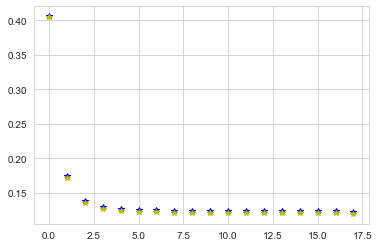

In [41]:
plt.plot(Tr_loss,'b*', Val_loss, 'y*')
plt.show()

In [42]:
"""   
i = 100
#print("Items in basket: ",get_items_from_ohe(test_x[i],unique_items))
print("Recommended item(s): ",get_items_from_ohe(item_preds[i],unique_items))
"""
model = NMF(n_components=100, init='random', random_state=0)
transation_w = model.fit_transform(item_preds)
items_h = model.components_

#get_items_from_ohe(items_h[1],unique_items)

print("Frequent item(s): ",get_items_from_ohe(items_h[0],unique_items))

Frequent item(s):  ['burgers' 'cake' 'chicken' 'chocolate' 'cookies' 'eggs' 'escalope'
 'french fries' 'frozen smoothie' 'frozen vegetables' 'grated cheese'
 'green tea' 'ground beef' 'low fat yogurt' 'milk' 'mineral water'
 'olive oil' 'pancakes' 'shrimp' 'spaghetti' 'tomatoes' 'turkey'
 'whole wheat rice']


In [43]:
total_transection=9835
for i in range(100):
    xx=np.asarray(np.nonzero(items_h[i]))
    [m,n]=(np.asarray(np.nonzero(items_h[i]))).shape
    support_A_B=len(np.intersect1d(np.nonzero(onehot_items[:,xx[0,n-1]]),np.nonzero(onehot_items[:,xx[0,n-2]])))/total_transection
    #print("{" + str(unique_items[xx[0,n-1]]) + "}" +"=>" "{" + str(unique_items[xx[0,n-2]]) + "}")
    [xxxx,sup_A]=(np.asarray(np.nonzero(onehot_items[:,xx[0,n-1]]))).shape
    [xxxx,sup_B]=(np.asarray(np.nonzero(onehot_items[:,xx[0,n-2]]))).shape
    support_A=sup_A/total_transection
    support_B=sup_B/total_transection
    confidence_A_B=support_A_B / (support_A)
    confidence_B_A=support_A_B / (support_B)
    #lift and conviction
    lift_A_B=confidence_A_B / support_B
    conviction_A_B=(1-support_B)/(1-confidence_A_B)
    print(i+1, "{" + str(unique_items[xx[0,n-1]]) + "}" +"=>" "{" + str(unique_items[xx[0,n-2]]) + "}"+" "+ "support="+ str(round(support_A_B,2)) +" "+ "confidence=" + str(round(confidence_A_B,2))  +" "+ "lift=" + str(round(lift_A_B,2))  +" "+ "conviction=" + str(round(conviction_A_B,2)) )


1 {whole wheat rice}=>{turkey} support=0.01 confidence=0.12 lift=2.53 conviction=1.08
2 {whole wheat rice}=>{turkey} support=0.01 confidence=0.12 lift=2.53 conviction=1.08
3 {whole wheat rice}=>{turkey} support=0.01 confidence=0.12 lift=2.53 conviction=1.08
4 {whole wheat rice}=>{turkey} support=0.01 confidence=0.12 lift=2.53 conviction=1.08
5 {whole wheat rice}=>{tomatoes} support=0.0 confidence=0.1 lift=1.97 conviction=1.06
6 {whole wheat rice}=>{turkey} support=0.01 confidence=0.12 lift=2.53 conviction=1.08
7 {whole wheat rice}=>{turkey} support=0.01 confidence=0.12 lift=2.53 conviction=1.08
8 {whole wheat rice}=>{turkey} support=0.01 confidence=0.12 lift=2.53 conviction=1.08
9 {whole wheat rice}=>{turkey} support=0.01 confidence=0.12 lift=2.53 conviction=1.08
10 {whole wheat rice}=>{turkey} support=0.01 confidence=0.12 lift=2.53 conviction=1.08
11 {whole wheat rice}=>{turkey} support=0.01 confidence=0.12 lift=2.53 conviction=1.08
12 {whole wheat rice}=>{turkey} support=0.01 confide

In [45]:
end = time.time()
print("Time consumed in working: ",end - start)

Time consumed in working:  704.3110842704773


#under Progress

In [44]:
#antecedents=[]
#consequents=[]
antecedents=str(unique_items[xx[0,n-1]])
consequents=str(unique_items[xx[0,n-2]])

temp = pd.DataFrame({'Support': str(round(support_A_B,2)), 'Confidence': str(round(confidence_A_B,2)), 'Lift': str(round(lift_A_B,2)), 'Conviction':str(round(conviction_A_B,2)) })
    result_ann = pd.concat([result_ann, temp])

result_ann.to_csv("result_ann.csv", sep=',') 

IndentationError: unexpected indent (<ipython-input-44-24ff34a3f6b2>, line 7)

In [30]:
temp = {'Support': str(round(support_A_B,2)), 'Confidence': str(round(confidence_A_B,2)), 'Lift': str(round(lift_A_B,2)), 'Conviction':str(round(conviction_A_B,2)) }
dataframe = pd.DataFrame(temp) 
dataframe.to_csv('result_ann.csv')

NameError: name 'support_A_B' is not defined